### Topic Names
#### Topic 0: Privacy and Safety Concerns and Opinions on Camera Surveillance
#### Topic 1: Personal Experiences and Directions
#### Topic 2: Object Descriptions and Movement Observations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim
import pyLDAvis
import warnings
import joblib

from tqdm import tqdm
from wordcloud import WordCloud
from empath import Empath
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
file_path = 'C:/Users/user/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24_with_best_topics_reduced_merged.csv'
df = pd.read_csv(file_path)
df.head(3)

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,processed_text,topic,probability,new_topic,new_topic_reduced,new_topics_merged
0,thread_start,2001-01-18 17:18:00,Questions about Estonia,89742,0,Society,# The world's going on #,- Why did an important piece of evidence (from...,important piece evidence front gate fall depth...,-1,"[0.00024663890393194777, 0.0002609580195334291...",-1,0,0
1,comment,2001-01-19 01:28:00,Questions about Estonia,89742,386913,Society,# The world's going on #,I think they had other things to do. - First o...,think thing first kin demanded sepulchre would...,-1,"[4.407680431440068e-05, 5.50752101119947e-05, ...",-1,0,0
2,comment,2001-01-19 06:21:00,Questions about Estonia,89742,386914,Society,# The world's going on #,"- Not the bow gate, but its SARANA- &gt; a str...",bow gate sarana strange coincidence fell resea...,-1,"[7.977215291569503e-05, 8.425016920408031e-05,...",-1,0,0


# Analysis

Topic 0: 234197 rows
Topic 1: 36651 rows
Topic 2: 2265 rows
Topic -1: 191 rows


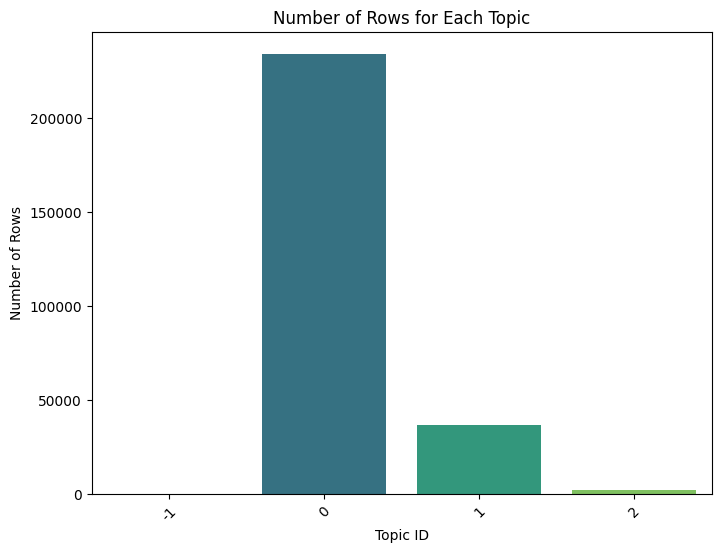

In [20]:
# Count the number of rows for each topic
topic_counts = df['new_topics_merged'].value_counts()
# topic_counts = df[df['new_topics_merged'] != -1]['new_topics_merged'].value_counts()


# Print the number of rows for each topic
for topic_id, count in topic_counts.items():
    print(f"Topic {topic_id}: {count} rows")


# Plot the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.xlabel('Topic ID')
plt.ylabel('Number of Rows')
plt.title('Number of Rows for Each Topic')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Initialize Empath
lexicon = Empath()

# Define a function to extract empath categories
def extract_empath_categories(text):
    return lexicon.analyze(text, normalize=True)

# Apply the function to each topic
tqdm.pandas(desc="Applying Empath Analysis")
empath_results = df['processed_text'].progress_apply(extract_empath_categories)

# Convert the results to a DataFrame
empath_df = pd.DataFrame(list(empath_results))
print(empath_df)

empath_df.to_csv("suomi24_empath_categories.csv")

Applying Empath Analysis: 100%|██████████| 273304/273304 [28:00<00:00, 162.63it/s]


,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.046875,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.016393,0.000000,0.000000,...,0.0,0.0,0.0,0.032787,0.016393,0.0,0.000000,0.0,0.016393,0.000000
2,0.0,0.014085,0.0,0.014085,0.0,0.000000,0.0,0.000000,0.014085,0.000000,...,0.0,0.0,0.0,0.014085,0.014085,0.0,0.000000,0.0,0.084507,0.000000
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.222222,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273299,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
273300,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.166667,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
273301,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
273302,0.0,0.000000,0.0,0.111111,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [21]:
empath_df_path = 'C:/Users/user/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24_empath_categories.csv'
empath_df = pd.read_csv(empath_df_path)
empath_df

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.046875,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.016393,0.000000,0.000000,...,0.0,0.0,0.0,0.032787,0.016393,0.0,0.000000,0.0,0.016393,0.000000
2,0.0,0.014085,0.0,0.014085,0.0,0.000000,0.0,0.000000,0.014085,0.000000,...,0.0,0.0,0.0,0.014085,0.014085,0.0,0.000000,0.0,0.084507,0.000000
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.222222,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273299,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
273300,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.166667,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
273301,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
273302,0.0,0.000000,0.0,0.111111,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


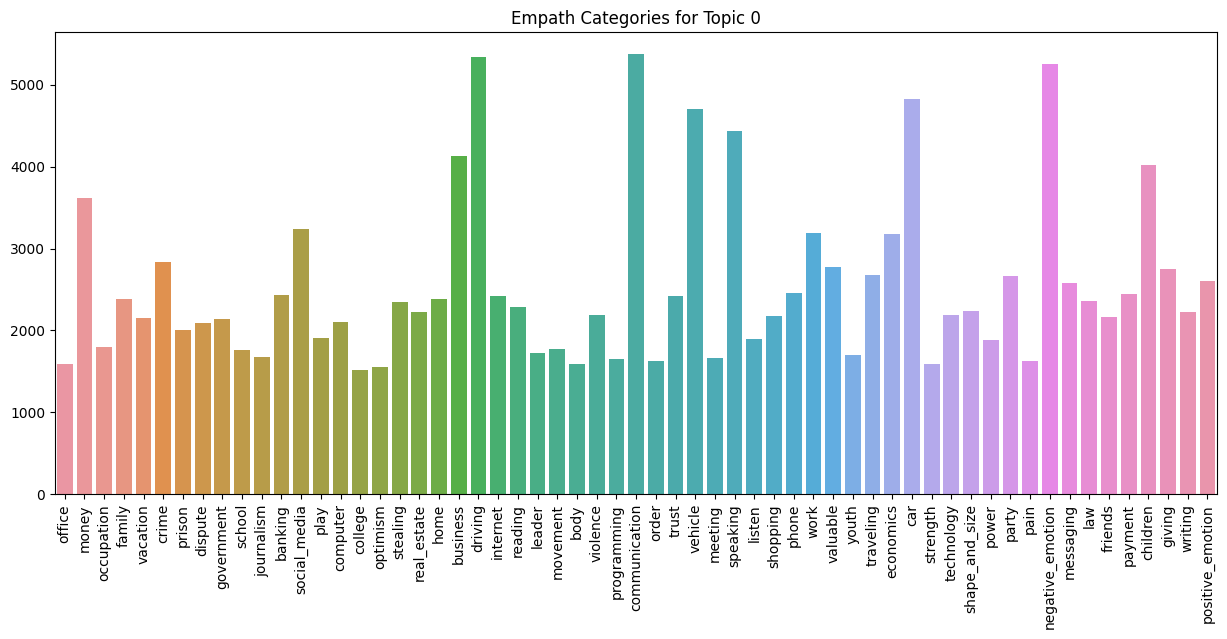

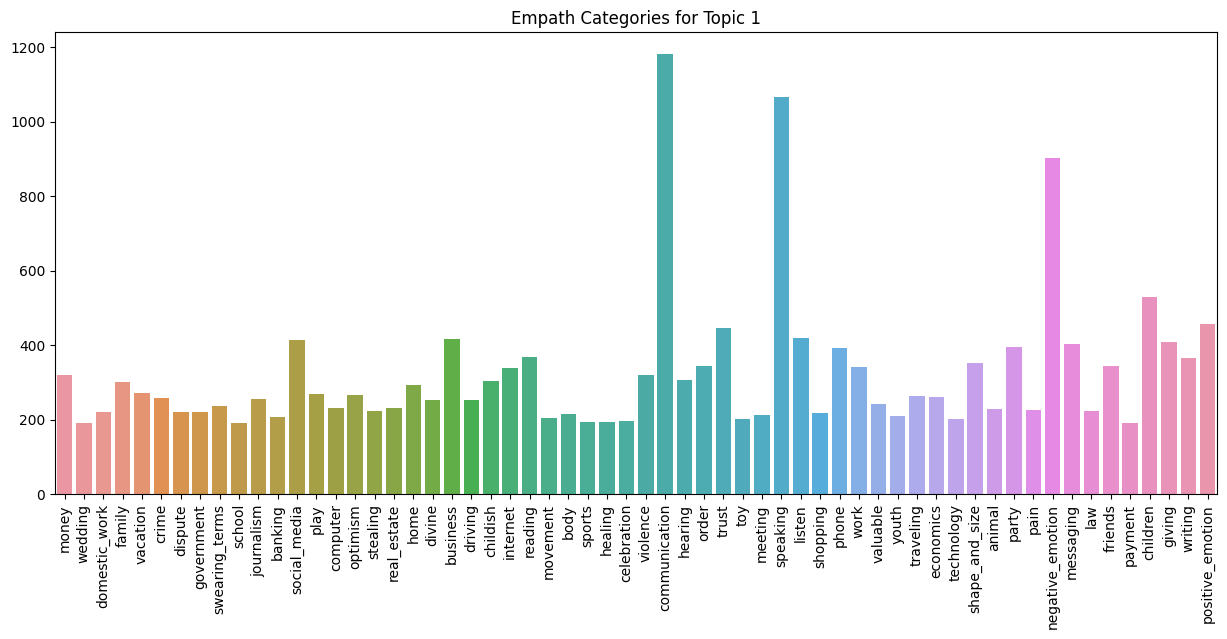

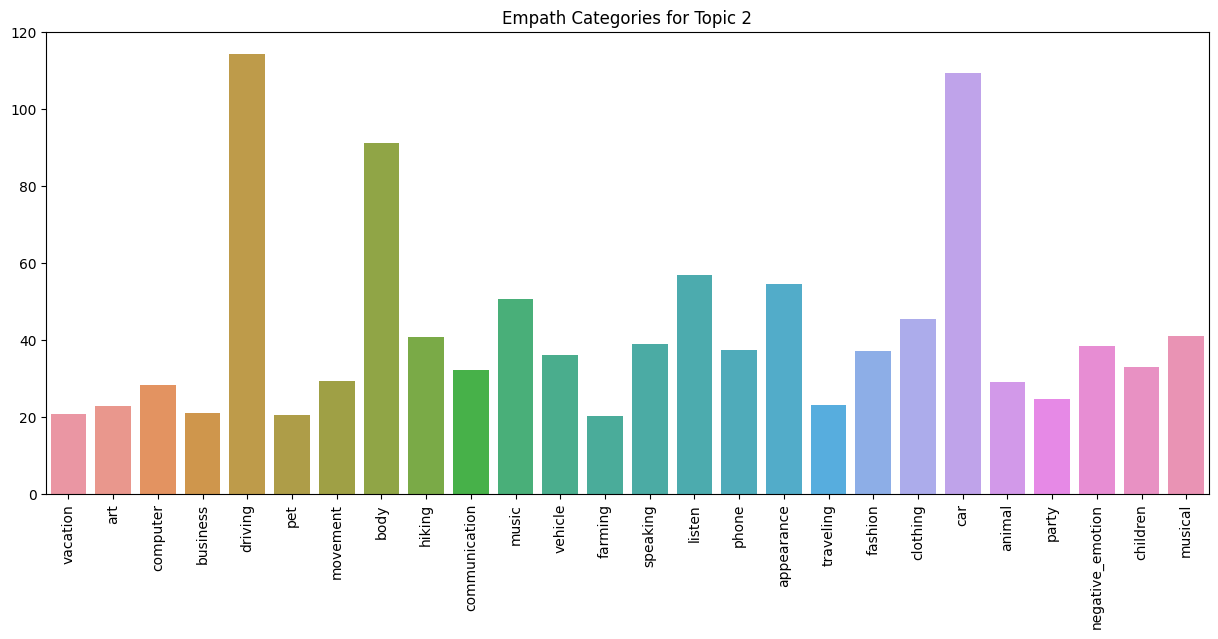

In [22]:

# Sum the empath categories for each topic
empath_sums = empath_df.groupby(df['new_topics_merged']).sum()
threshold = [1500,190,20]
# Plot the empath categories for each topic
for topic_id in empath_sums.index:
    if topic_id != -1:  # Skip outliers
        
        topic_data = empath_sums.loc[topic_id]
        relevant_data = topic_data[topic_data > threshold[topic_id]]
        
        plt.figure(figsize=(15, 6))
        sns.barplot(x=relevant_data.index, y=relevant_data.values)
        plt.title(f"Empath Categories for Topic {topic_id}")
        plt.xticks(rotation=90)
        plt.show()


C:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


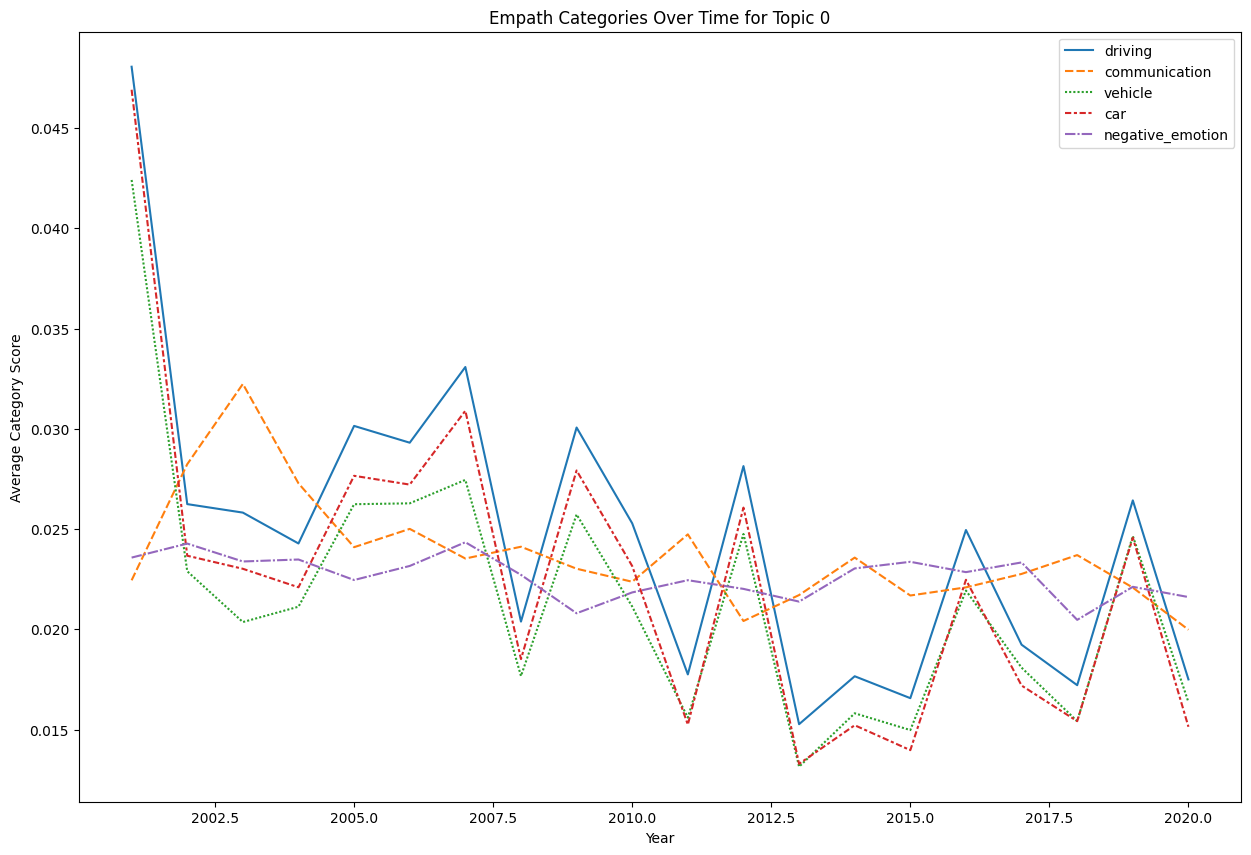

C:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


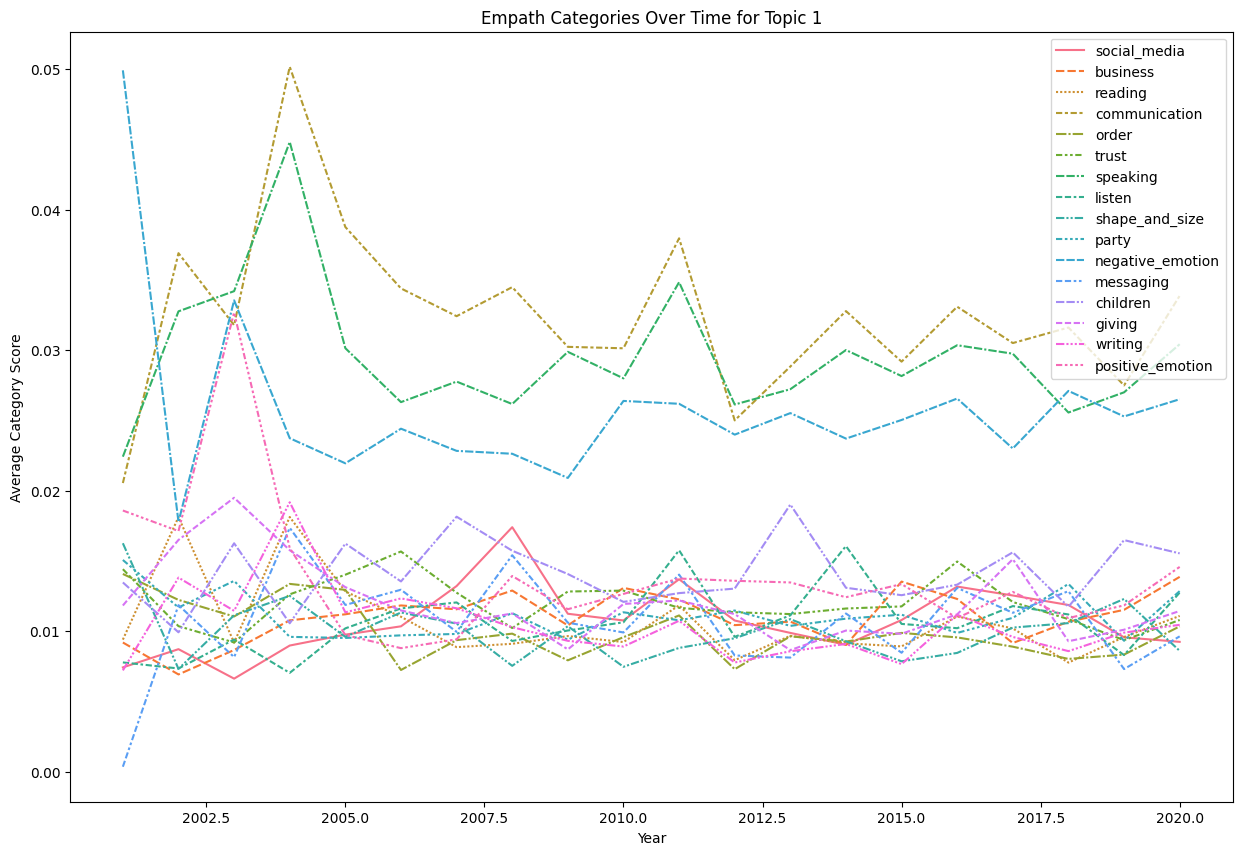

C:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


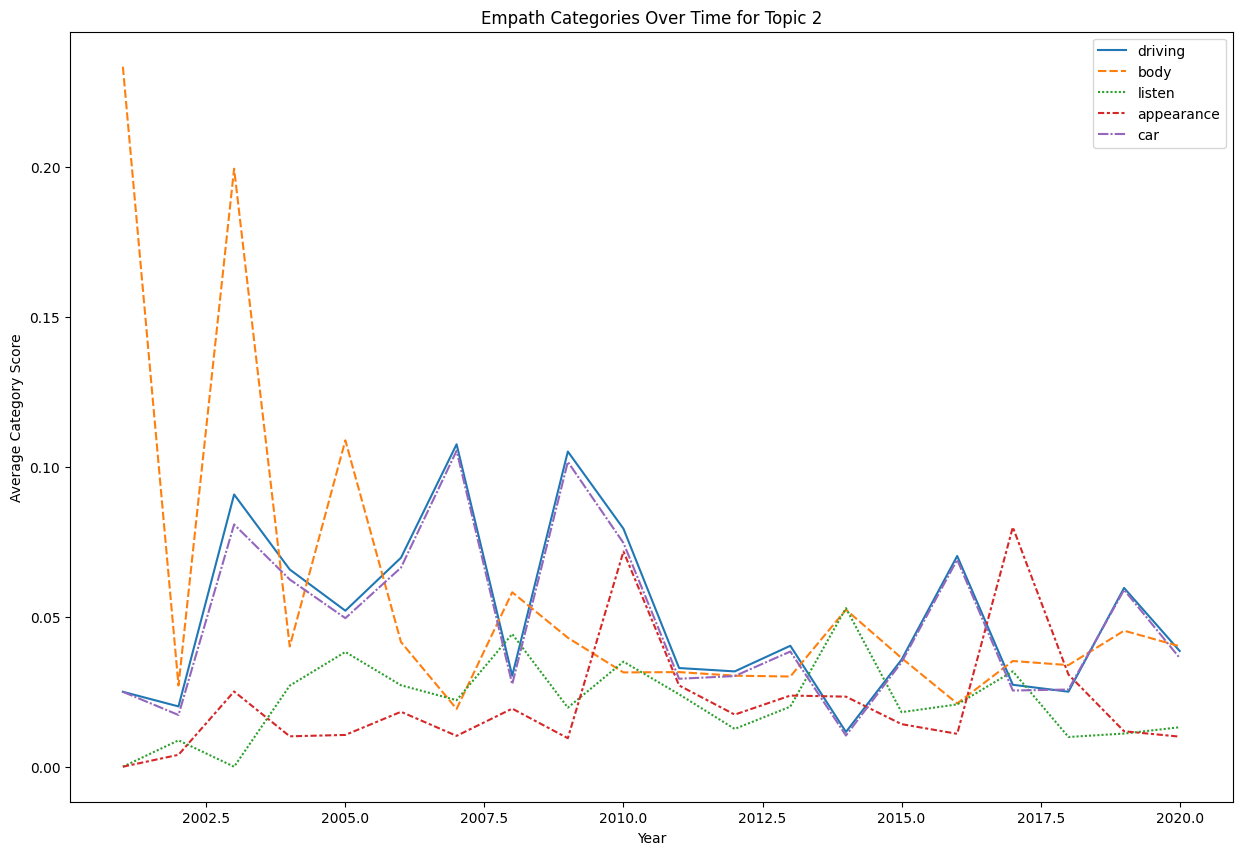

In [23]:
# Group by year and topic
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
empath_yearly = pd.concat([df['year'], empath_df], axis=1)
empath_yearly = empath_yearly.groupby(['year', df['new_topics_merged']]).mean()

threshold = [0.02,0.01,0.02]

# Plot the empath categories over time for each topic
for topic_id in df['new_topics_merged'].unique():
    if topic_id != -1:  # Skip outliers
        topic_trend = empath_yearly.xs(topic_id, level=1)
        topic_trend_filtered = topic_trend.loc[:, (topic_trend.mean() > threshold[topic_id])]

        
        plt.figure(figsize=(15, 10))
        sns.lineplot(data=topic_trend_filtered)
        plt.title(f"Empath Categories Over Time for Topic {topic_id}")
        plt.xlabel('Year')
        plt.ylabel('Average Category Score')
        plt.legend(loc='upper right')
        plt.show()


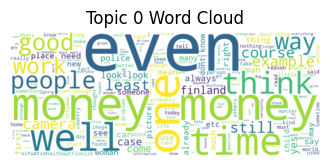

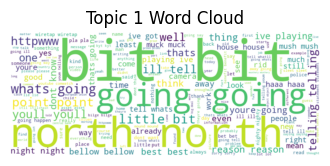

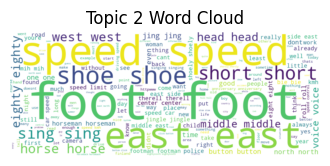

In [24]:

# Define a function to generate a word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(text)
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each topic
for topic_id in df['new_topics_merged'].unique():
    if topic_id != -1:  # Skip outliers
        topic_texts = ' '.join(df[df['new_topics_merged'] == topic_id]['processed_text'])
        generate_wordcloud(topic_texts, f"Topic {topic_id} Word Cloud")


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Assuming `df` is your DataFrame and 'processed_text' contains the text data
# text_data = df['processed_text']
text_data = df[df['new_topics_merged'] == 0]['processed_text']

# Tokenize and count terms
term_counts = Counter()
for text in text_data:
    term_counts.update(text.split())

# Convert to DataFrame for easier manipulation
term_counts_df = pd.DataFrame(term_counts.items(), columns=['term', 'count'])

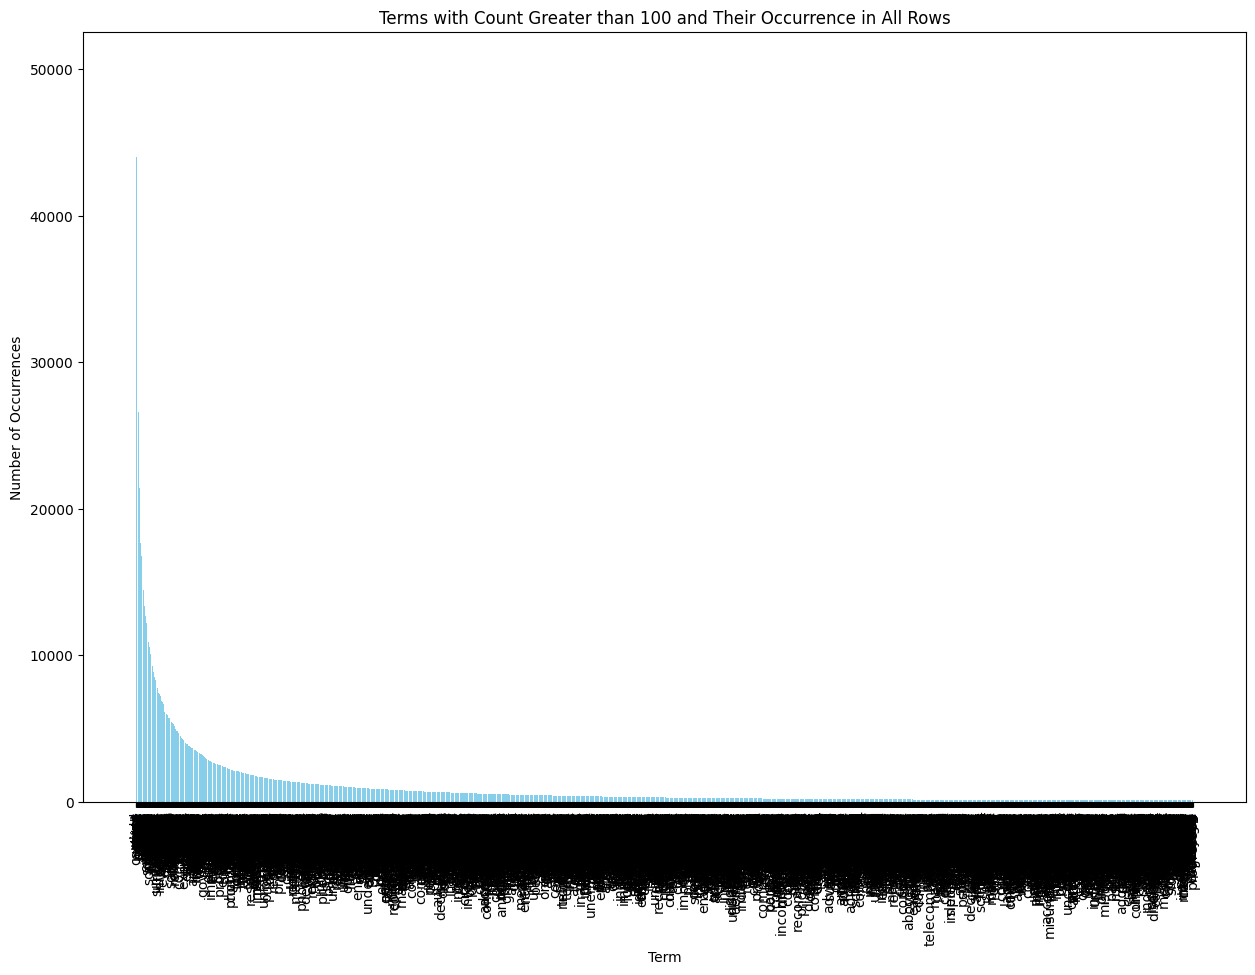

In [45]:
filtered_terms = None
# Filter terms with a count greater than 100
filtered_terms = term_counts_df[term_counts_df['count'] > 100]

# Sort the DataFrame for better visualization
filtered_terms = filtered_terms.sort_values(by='count', ascending=False)

# Plotting the results
plt.figure(figsize=(15, 10))
plt.bar(filtered_terms['term'], filtered_terms['count'], color='skyblue')
plt.title('Terms with Count Greater than 100 and Their Occurrence in All Rows')
plt.xlabel('Term')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.show()

In [49]:
# filtered_terms = term_counts_df[term_counts_df['count'] > 100]
filtered_terms = term_counts_df[(term_counts_df['count'] > 100) & (term_counts_df['count'] < 1000)]

len(filtered_terms)

4376

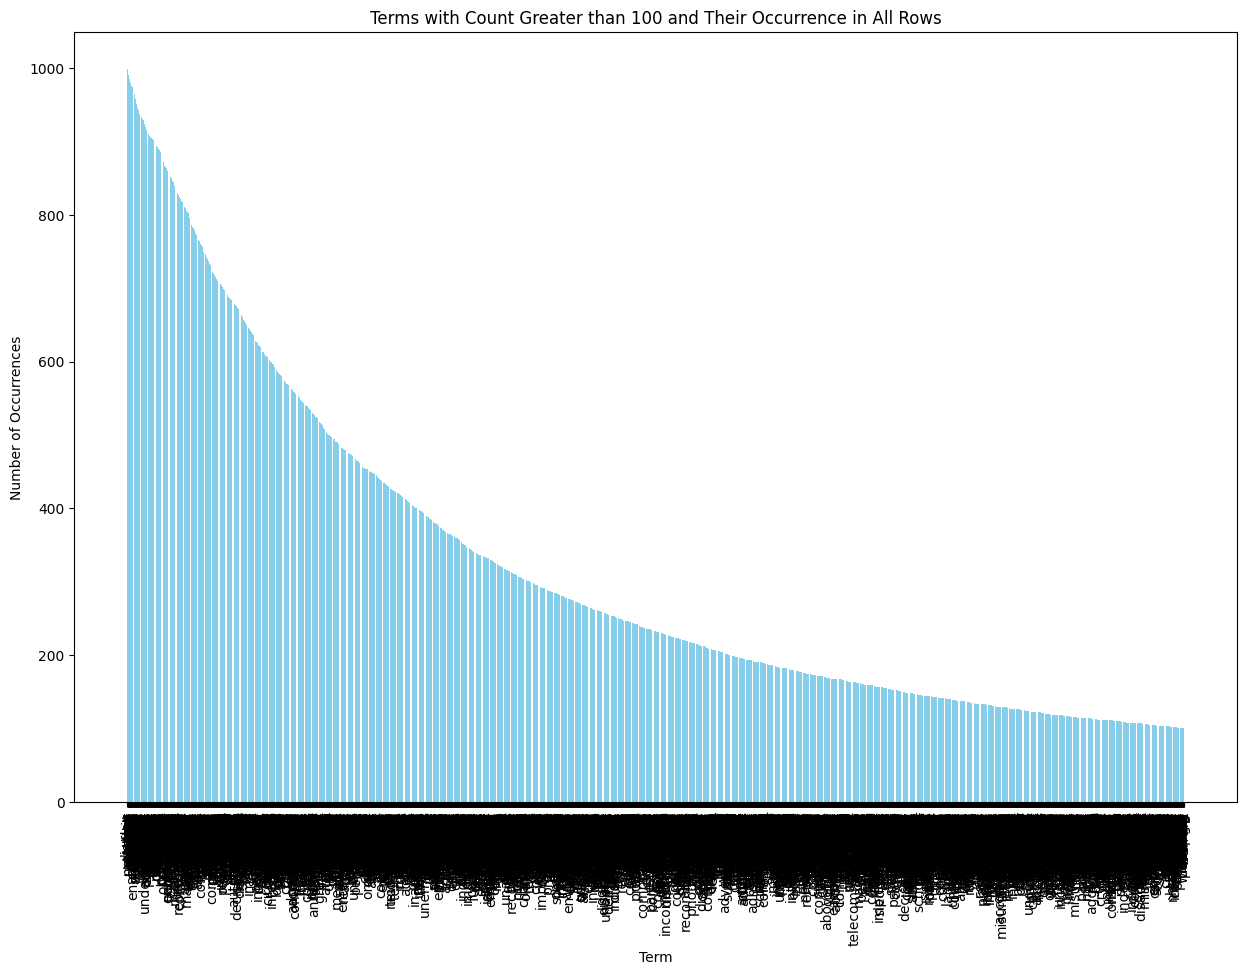

In [50]:
filtered_terms = None

# Filter terms with a count greater than 100
filtered_terms = term_counts_df[(term_counts_df['count'] > 100) & (term_counts_df['count'] < 1000)]

# Sort the DataFrame for better visualization
filtered_terms = filtered_terms.sort_values(by='count', ascending=False)

# Plotting the results
plt.figure(figsize=(15, 10))
plt.bar(filtered_terms['term'], filtered_terms['count'], color='skyblue')
plt.title('Terms with Count Greater than 100 and Their Occurrence in All Rows')
plt.xlabel('Term')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.show()

# Kmeans for topic dividing

In [13]:
topic_data = df[df['new_topics_merged'] == 0]['processed_text'].dropna().tolist()

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Adjust max_features as needed
X = vectorizer.fit_transform(topic_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, verbose=0)  # Splitting into 2 subtopics
topic_data_subtopics = kmeans.fit_predict(X)

# Predict the cluster labels
labels = kmeans.labels_

# Evaluate the clustering performance
sil_score = silhouette_score(X, labels)
db_index = davies_bouldin_score(X.toarray(), labels)

print(f'Silhouette Score: {sil_score}')
print(f'Davies-Bouldin Index: {db_index}')

Silhouette Score: 0.0042226291407216
Davies-Bouldin Index: 9.458279363273162


C:\Users\user\anaconda3\envs\py311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.00422261501756616
Davies-Bouldin Index: 9.457679028979113


C:\Users\user\anaconda3\envs\py311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


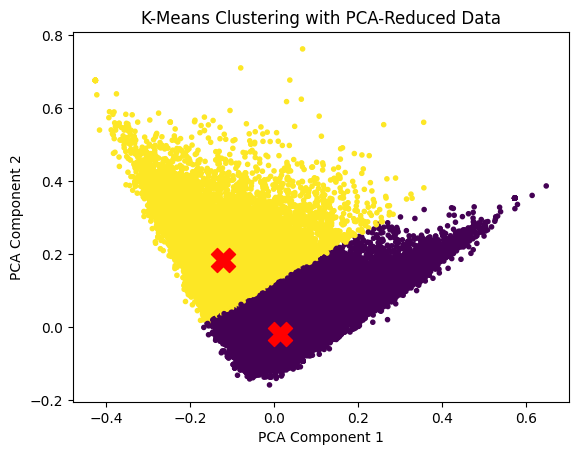

In [6]:
topic_data = df[df['new_topics_merged'] == 0]['processed_text'].dropna().tolist()

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Adjust the parameters as needed
X = vectorizer.fit_transform(topic_data)

# Fit the K-Means model
optimal_k = 2  # Set the optimal number of clusters based on previous analysis
kmeans = KMeans(n_clusters=optimal_k)
topic_data_subtopics = kmeans.fit_predict(X)

# Predict the cluster labels
labels = kmeans.labels_

# Evaluate the clustering performance
sil_score = silhouette_score(X, labels)
db_index = davies_bouldin_score(X.toarray(), labels)

print(f'Silhouette Score: {sil_score}')
print(f'Davies-Bouldin Index: {db_index}')

In [20]:

# Assuming 'kmeans' is the trained KMeans model
joblib_file = "kmeans_model_1000.pkl"  
joblib.dump(kmeans, joblib_file)

joblib_file_vectorizer = "tfidf_vectorizer_model_1000.pkl"
joblib.dump(vectorizer, joblib_file_vectorizer)

['tfidf_vectorizer_model_1000.pkl']

In [17]:
# Add the clusters to the DataFrame
# df.loc[df['new_topics_merged'] == 0, 'subtopics'] = topic_data_subtopics

# Get feature names (terms)
terms = vectorizer.get_feature_names_out()

# Get the centroids of each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Print the top terms for each cluster
for i in range(kmeans.n_clusters):
    print(f"Subtopic {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :30]]  # Top 10 terms
    print("Top terms:", top_terms)

# K-MEANS SUB-TOPICS DERIVED FROM BERTOPIC TOPIC 0 

Subtopic 0:
Top terms: ['dont', 'youre', 'know', 'think', 'get', 'dont know', 'dont think', 'even', 'like', 'want', 'there', 'people', 'thing', 'time', 'anything', 'one', 'going', 'good', 'dont want', 'really', 'cant', 'well', 'camera', 'ive', 'understand', 'doesnt', 'thats', 'take', 'need', 'would']
Subtopic 1:
Top terms: ['would', 'camera', 'even', 'one', 'time', 'get', 'people', 'good', 'also', 'police', 'car', 'thing', 'well', 'like', 'think', 'year', 'finland', 'right', 'way', 'come', 'work', 'take', 'could', 'already', 'speed', 'many', 'still', 'always', 'know', 'see']


In [21]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,processed_text,topic,probability,new_topic,new_topic_reduced,new_topics_merged
0,thread_start,2001-01-18 17:18:00,Questions about Estonia,89742,0,Society,# The world's going on #,- Why did an important piece of evidence (from...,important piece evidence front gate fall depth...,-1,"[0.00024663890393194777, 0.0002609580195334291...",-1,0,0
1,comment,2001-01-19 01:28:00,Questions about Estonia,89742,386913,Society,# The world's going on #,I think they had other things to do. - First o...,think thing first kin demanded sepulchre would...,-1,"[4.407680431440068e-05, 5.50752101119947e-05, ...",-1,0,0
2,comment,2001-01-19 06:21:00,Questions about Estonia,89742,386914,Society,# The world's going on #,"- Not the bow gate, but its SARANA- &gt; a str...",bow gate sarana strange coincidence fell resea...,-1,"[7.977215291569503e-05, 8.425016920408031e-05,...",-1,0,0
3,comment,2001-01-19 16:27:00,Questions about Estonia,89742,386915,Society,# The world's going on #,I'll tell you what's going on. I'll tell you w...,ill tell whats going ill tell whatll news,303,"[7.667691904612715e-307, 6.021115893014672e-30...",1,1,1
4,comment,2001-01-20 12:49:00,Questions about Estonia,89742,386916,Society,# The world's going on #,Let the cause of the sinking of any ship be li...,let cause sinking ship lifted away wreckage le...,-1,"[0.0007525256358938008, 0.0005162089872065458,...",-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273299,comment,2020-12-31 17:08:00,Thai rice dogs,16711386,105838676,Tourism,Pattaya,"as if these omega- ""men"" were taken there. The...",omega men taken comedian claim nasumarttaamal ...,-1,"[0.00016245547147837938, 0.0001466891115713836...",-1,0,0
273300,thread_start,2020-12-30 17:58:00,Surveillance camera,16711801,0,Home and construction,Lighting and electrical works,Surveillance camera Is there a human next outs...,surveillance camera human next outside camera,72,"[0.0005654172215899637, 0.00042500193234270276...",0,0,0
273301,comment,2020-12-31 06:34:00,Surveillance camera,16711801,105829873,Home and construction,Lighting and electrical works,Pretty sure the camera will follow you. Put th...,pretty sure camera follow put security camera ...,-1,"[0.0005130415058729868, 0.0003921143112700931,...",-1,0,0
273302,comment,2020-12-31 13:27:00,Surveillance camera,16711801,105835154,Home and construction,Lighting and electrical works,please see online if you have Internet access ...,please see online internet access baron kepele...,745,"[0.0005287715655722738, 0.00043761060293182004...",1,1,1


In [22]:
df.loc[df['new_topics_merged'] == 0, 'subtopics'] = topic_data_subtopics
df.to_csv("suomi24_kmeans_divided_topics.csv", index=False)

# LDA also for dividing topic

In [3]:
lda_data = df[df['new_topics_merged'] == 0]['processed_text']
lda_data

0         important piece evidence front gate fall depth...
1         think thing first kin demanded sepulchre would...
2         bow gate sarana strange coincidence fell resea...
9         look look road look look look look look look l...
10        dont know lehtola missed fact estonia built ir...
                                ...                        
273297    always plane always face elephant water still ...
273298    especially ability know thing others kind prob...
273299    omega men taken comedian claim nasumarttaamal ...
273300        surveillance camera human next outside camera
273301    pretty sure camera follow put security camera ...
Name: processed_text, Length: 234197, dtype: object

In [4]:
def sent_to_words(texts):
    for text in texts:
        yield(simple_preprocess(str(text),deacc=True))  # deacc=True removes the punctuation marks
        
data_words=list(sent_to_words(lda_data))
# data_words=list(sent_to_words(df_relevant['processed_text']))

In [5]:
# Applying Bigrams and trigrams 
bigram=gensim.models.Phrases(data_words,min_count=5,threshold=80)

bigram_mod=gensim.models.phrases.Phraser(bigram)

def make_bigram(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_nostops_bigrams=make_bigram(data_words)

In [6]:
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

def lemmatize(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out=[]
    for sent in texts:
        doc=nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    return texts_out
    
data_lemmatized = lemmatize(data_words_nostops_bigrams,allowed_postags=['NOUN','ADJ','VERB','ADV'] )

In [7]:
id2word=corpora.Dictionary(data_lemmatized)
texts=data_lemmatized  # list of list of tokens
corpus=[id2word.doc2bow(text) for text in texts]
print(corpus[:1])   #first document

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)]]



Training for passes: 5
Passes: 5, Perplexity: -7.877217098392009, Coherence Score: 0.5407711242603548

Training for passes: 10
Passes: 10, Perplexity: -7.877639774726493, Coherence Score: 0.5407711242603548

Training for passes: 15
Passes: 15, Perplexity: -7.877253468653992, Coherence Score: 0.5407711242603548

Training for passes: 20
Passes: 20, Perplexity: -7.877212237279201, Coherence Score: 0.5397736327458478


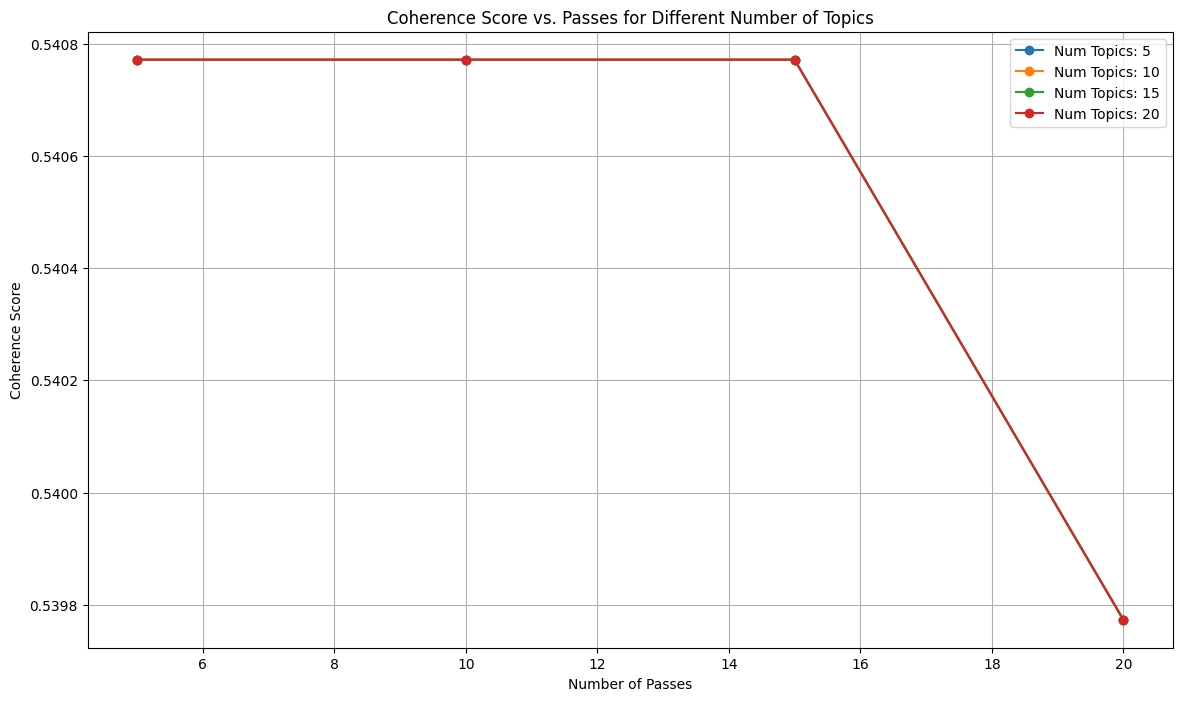

In [8]:
# passes_array = [5,10,15,20]
# coherence_scores = []

# for passes in passes_array:
#     # building LDA Model
#     print(f"\nTraining for passes: {passes}")
#     lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=2,random_state=100,update_every=0,
#                                          chunksize=500,passes=passes,alpha='auto',per_word_topics=True)
#     coherence_model_lda=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word,coherence='c_v')    
#     coherence_score=coherence_model_lda.get_coherence()
#     coherence_scores.append((passes, coherence_score))
#     print(f'Passes: {passes}, Perplexity: {lda_model.log_perplexity(corpus)}, Coherence Score: {coherence_score}')

# # Plot the coherence scores
# plt.figure(figsize=(14, 8))
# for num_topics, coherence_score in coherence_scores:
#     passes_values, scores = zip(*coherence_scores)
#     plt.plot(passes_values, scores, marker='o', label=f'Num Topics: {num_topics}')

# plt.title('Coherence Score vs. Passes for Different Number of Topics')
# plt.xlabel('Number of Passes')
# plt.ylabel('Coherence Score')
# plt.legend()
# plt.grid(True)
# plt.show()

In [9]:
# building LDA Model
lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=2,random_state=100,update_every=0,
                                     chunksize=500,passes=5,alpha='auto',per_word_topics=True)
coherence_model_lda=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word,coherence='c_v')    
coherence_score=coherence_model_lda.get_coherence()
coherence_scores.append((passes, coherence_score))
print(f'Perplexity: {lda_model.log_perplexity(corpus)}, Coherence Score: {coherence_score}')

Perplexity: -7.877217098392009, Coherence Score: 0.5407711242603548


In [10]:
warnings.filterwarnings('ignore',category=FutureWarning)

pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.003385  0.0       1        1  66.031233
1     -0.003385  0.0       2        1  33.968767, topic_info=      Term          Freq         Total Category  logprob  loglift
11    even  43777.000000  43777.000000  Default  30.0000  30.0000
93    good  30420.000000  30420.000000  Default  29.0000  29.0000
129   know  29647.000000  29647.000000  Default  28.0000  28.0000
81   think  34120.000000  34120.000000  Default  27.0000  27.0000
98    look  28455.000000  28455.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
344    see   6681.436402  21241.646588   Topic2  -5.5573  -0.0769
133   make   6663.370941  21169.637271   Topic2  -5.5600  -0.0762
281    lot   5845.037039  16975.839699   Topic2  -5.6910   0.0135
114   year   6041.953668  19545.024441   Topic2  -5.6579  -0.0943
306    use   5611.197812  20128.857199   Topic2  -5.7318  -0.1977

[203 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
777        1  0.763832        age
777        2  0.236279        age
23532      1  0.785370    alarmed
23532      2  0.184793    alarmed
159        1  0.720321    already
...      ...       ...        ...
11080      2  0.214090  wideangle
579        1  0.648542       work
579        2  0.351458       work
114        1  0.690866       year
114        2  0.309132       year

[296 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

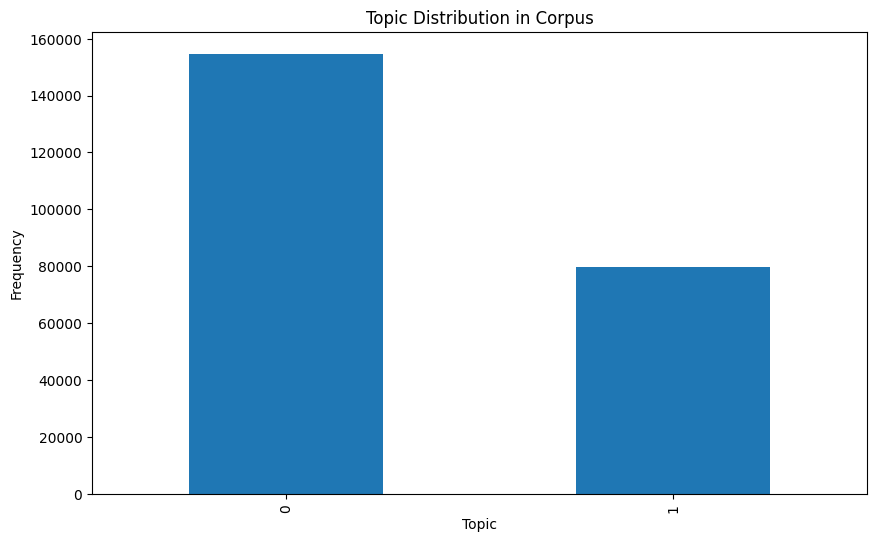

In [11]:
topic_distribution = [lda_model.get_document_topics(bow) for bow in corpus]

# Convert the topic distribution to a DataFrame
# Each document will have a distribution of topics (tuples of (topic_id, probability))
topic_df = pd.DataFrame([dict(doc) for doc in topic_distribution]).fillna(0)

# Plot the distribution of topics across the corpus
plt.figure(figsize=(10, 6))
topic_df.sum().plot(kind='bar')
plt.title('Topic Distribution in Corpus')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.show()

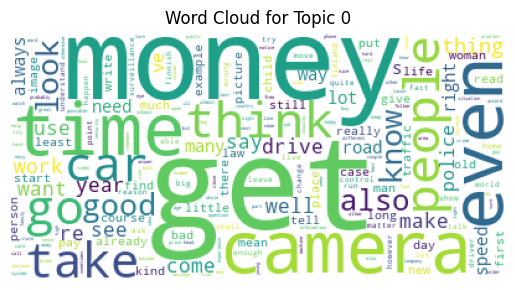

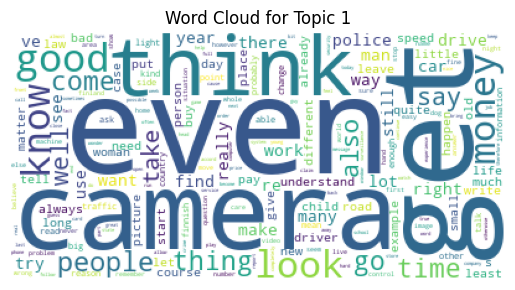

In [12]:
# Generate word clouds for each topic
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis('off')
    plt.title(f'Word Cloud for Topic {t}')
    plt.show()


In [14]:
for idx, topic in lda_model.print_topics(num_words=50):
    print(f"\nLDA Sub-topicsTopic 0.{idx+1}: {topic}")

# LDA SUB-TOPICS DERIVED FROM BERTOPIC TOPIC 0 


LDA Sub-topicsTopic 0.1: 0.011*"get" + 0.008*"money" + 0.008*"time" + 0.008*"even" + 0.008*"camera" + 0.007*"think" + 0.006*"people" + 0.006*"go" + 0.006*"take" + 0.006*"car" + 0.005*"good" + 0.005*"know" + 0.005*"look" + 0.005*"also" + 0.005*"thing" + 0.005*"come" + 0.005*"well" + 0.004*"re" + 0.004*"say" + 0.004*"see" + 0.004*"use" + 0.004*"make" + 0.004*"want" + 0.004*"drive" + 0.004*"year" + 0.004*"work" + 0.004*"police" + 0.003*"right" + 0.003*"lot" + 0.003*"speed" + 0.003*"road" + 0.003*"way" + 0.003*"s" + 0.003*"ve" + 0.003*"many" + 0.003*"always" + 0.003*"need" + 0.003*"already" + 0.003*"much" + 0.003*"man" + 0.003*"little" + 0.003*"tell" + 0.003*"long" + 0.003*"really" + 0.003*"place" + 0.003*"picture" + 0.003*"still" + 0.003*"child" + 0.003*"find" + 0.003*"start"

LDA Sub-topicsTopic 0.2: 0.010*"even" + 0.009*"get" + 0.007*"camera" + 0.007*"think" + 0.007*"good" + 0.007*"know" + 0.006*"look" + 0.006*"money" + 0.006*"people" + 0.005*"thing" + 0.005*"go" + 0.005*"time" + 0.005

# LDA Topic 0.1: Privacy Concerns
# LDA Topic 0.2: Security and Safety Concerns

In [50]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,processed_text,topic,probability,new_topic,new_topic_reduced,new_topics_merged,subtopics
0,thread_start,2001-01-18 17:18:00,Questions about Estonia,89742,0,Society,# The world's going on #,- Why did an important piece of evidence (from...,important piece evidence front gate fall depth...,-1,"[0.00024663890393194777, 0.0002609580195334291...",-1,0,0,1.0
1,comment,2001-01-19 01:28:00,Questions about Estonia,89742,386913,Society,# The world's going on #,I think they had other things to do. - First o...,think thing first kin demanded sepulchre would...,-1,"[4.407680431440068e-05, 5.50752101119947e-05, ...",-1,0,0,1.0
2,comment,2001-01-19 06:21:00,Questions about Estonia,89742,386914,Society,# The world's going on #,"- Not the bow gate, but its SARANA- &gt; a str...",bow gate sarana strange coincidence fell resea...,-1,"[7.977215291569503e-05, 8.425016920408031e-05,...",-1,0,0,1.0
3,comment,2001-01-19 16:27:00,Questions about Estonia,89742,386915,Society,# The world's going on #,I'll tell you what's going on. I'll tell you w...,ill tell whats going ill tell whatll news,303,"[7.667691904612715e-307, 6.021115893014672e-30...",1,1,1,NaN
4,comment,2001-01-20 12:49:00,Questions about Estonia,89742,386916,Society,# The world's going on #,Let the cause of the sinking of any ship be li...,let cause sinking ship lifted away wreckage le...,-1,"[0.0007525256358938008, 0.0005162089872065458,...",-1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273299,comment,2020-12-31 17:08:00,Thai rice dogs,16711386,105838676,Tourism,Pattaya,"as if these omega- ""men"" were taken there. The...",omega men taken comedian claim nasumarttaamal ...,-1,"[0.00016245547147837938, 0.0001466891115713836...",-1,0,0,1.0
273300,thread_start,2020-12-30 17:58:00,Surveillance camera,16711801,0,Home and construction,Lighting and electrical works,Surveillance camera Is there a human next outs...,surveillance camera human next outside camera,72,"[0.0005654172215899637, 0.00042500193234270276...",0,0,0,1.0
273301,comment,2020-12-31 06:34:00,Surveillance camera,16711801,105829873,Home and construction,Lighting and electrical works,Pretty sure the camera will follow you. Put th...,pretty sure camera follow put security camera ...,-1,"[0.0005130415058729868, 0.0003921143112700931,...",-1,0,0,1.0
273302,comment,2020-12-31 13:27:00,Surveillance camera,16711801,105835154,Home and construction,Lighting and electrical works,please see online if you have Internet access ...,please see online internet access baron kepele...,745,"[0.0005287715655722738, 0.00043761060293182004...",1,1,1,NaN


In [51]:
doc_lda=lda_model[corpus]
print(list(doc_lda)[0])

([(0, 0.4367927), (1, 0.5632073)], [(0, [1, 0]), (1, [0, 1]), (2, [0, 1]), (3, [1, 0]), (4, [1, 0]), (5, [1, 0]), (6, [1, 0]), (7, [1, 0]), (8, [1, 0]), (9, [1, 0]), (10, [1, 0]), (11, [1, 0]), (12, [0, 1]), (13, [1, 0]), (14, [1, 0]), (15, [1, 0]), (16, [1, 0]), (17, [1, 0]), (18, [1, 0]), (19, [1, 0]), (20, [1, 0]), (21, [1, 0]), (22, [1, 0]), (23, [0, 1]), (24, [0, 1]), (25, [1, 0]), (26, [1, 0]), (27, [1, 0]), (28, [1, 0]), (29, [1, 0]), (30, [1, 0]), (31, [1, 0]), (32, [1, 0]), (33, [0, 1]), (34, [1, 0]), (35, [1, 0]), (36, [1, 0]), (37, [1, 0]), (38, [1, 0]), (39, [1, 0]), (40, [0, 1]), (41, [1, 0]), (42, [1, 0]), (43, [1, 0]), (44, [1, 0]), (45, [0, 1]), (46, [1, 0])], [(0, [(0, 0.43688467), (1, 0.5623567)]), (1, [(0, 0.50297344), (1, 0.49692407)]), (2, [(0, 0.521847), (1, 0.47772098)]), (3, [(0, 0.4605454), (1, 0.5381785)]), (4, [(0, 0.35416546), (1, 0.58879745)]), (5, [(0, 0.38500917), (1, 0.6147621)]), (6, [(0, 0.38984358), (1, 0.608742)]), (7, [(0, 0.46373802), (1, 0.5361547

In [16]:
# import pandas as pd
# from gensim.models.ldamodel import LdaModel
# from gensim import corpora

# Simulated part where LDA model and corpus are defined
# Assuming lda_model and corpus are already defined

# Find dominant topics
dominant_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] + 3 for doc in corpus]

# # Create a temporary DataFrame to safely handle the assignment
# temp_df = df.loc[df['new_topics_merged'] == 0].copy()
# temp_df['final_topics'] = dominant_topics  # Assuming alignment in size

# # Update the main DataFrame
# df.update(temp_df)

df.loc[df['new_topics_merged'] == 0, 'final_topics'] = dominant_topics


# Assign topic IDs to the other rows as originally intendedA
df.loc[df['new_topics_merged'] == 1, 'final_topics'] = 1
df.loc[df['new_topics_merged'] == 2, 'final_topics'] = 2

# Mapping topic IDs to names (optional)
topic_names = {
    1: 'Personal Experiences and Directions',
    2: 'General Observations and Comments',
    3: 'Privacy Concerns',
    4: 'Security and Safety Concerns'
}

df['topic_names'] = df['final_topics'].map(topic_names)

# Save the DataFrame to CSV
df.to_csv('suomi24_lda_final_topics.csv', index=False)

# Print the DataFrame to verify
df


       msg_type             datetime                    title  thread_id  \
0  thread_start  2001-01-18 17:18:00  Questions about Estonia      89742   
1       comment  2001-01-19 01:28:00  Questions about Estonia      89742   
2       comment  2001-01-19 06:21:00  Questions about Estonia      89742   
3       comment  2001-01-19 16:27:00  Questions about Estonia      89742   
4       comment  2001-01-20 12:49:00  Questions about Estonia      89742   

   comment_id topic_name_top           topic_name_leaf  \
0           0        Society  # The world's going on #   
1      386913        Society  # The world's going on #   
2      386914        Society  # The world's going on #   
3      386915        Society  # The world's going on #   
4      386916        Society  # The world's going on #   

                                         thread_text  \
0  - Why did an important piece of evidence (from...   
1  I think they had other things to do. - First o...   
2  - Not the bow gate, but

In [21]:
df['final_topics'].value_counts()

final_topics
3.0    234197
1.0     36651
2.0      2265
Name: count, dtype: int64

In [22]:
df['new_topics_merged'].value_counts()

new_topics_merged
 0    234197
 1     36651
 2      2265
-1       191
Name: count, dtype: int64

In [47]:
for doc in corpus:  # Adjust the slice as needed
    # print(f'\ndoc: {doc}')
    topic1 = lda_model[doc][0][0][1]
    topic2 = lda_model[doc][0][1][1]
    # print(f'\nlda_model[doc]: {lda_model[doc][0]}')
    # print(f'\nlda_model[doc]: {topic1}')
    # print(f'\nlda_model[doc]: {topic2}')
    if topic1 < topic2:
        print('topic 1')
    # else:
    #     print('topic 0')
    # print(lda_model[doc])